In [100]:
import cell_logger

In [101]:
%%log
import numpy as np
import keras
from PIL import Image
import scipy.interpolate
import scipy.misc
import matplotlib.pyplot as plt


In [102]:
%%log
import os

def array_from_folder(path):
    pics = os.listdir(path)
    pics.sort()
    pics = [np.array(Image.open(os.path.join(path, p))) for p in pics]
    pics = np.array(pics)
    return pics

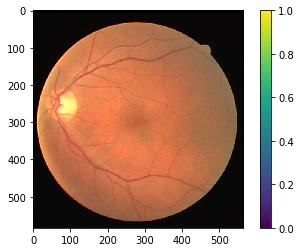

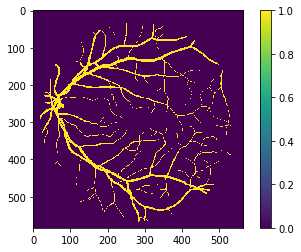

In [103]:
train_inputs = array_from_folder("DRIVE/training/images/") / 255.
train_outputs = np.expand_dims(array_from_folder("DRIVE/training/1st_manual/"), -1) / 255.

train_outputs = np.concatenate([train_outputs, 1-train_outputs], -1)

test_inputs = array_from_folder("DRIVE/test/images/") / 255.
test_outputs = np.expand_dims(array_from_folder("DRIVE/test/1st_manual/"), -1) / 255.

test_outputs = np.concatenate([test_outputs, 1-test_outputs], -1)

plt.imshow(train_inputs[0])
plt.colorbar()
plt.show()

plt.imshow(train_outputs[0, :, :, 0])
plt.colorbar()
plt.show()


In [104]:
%%log
augmented_inputs  = []
augmented_outputs = []

for i in range(300):
    dx = np.random.randint(train_inputs.shape[2] - 128)
    dy = np.random.randint(train_inputs.shape[1] - 128)
    augmented_inputs.append(train_inputs[:, dy:dy + 128, dx:dx + 128])
    augmented_outputs.append(train_outputs[:, dy:dy + 128, dx:dx + 128])
    
augmented_inputs = np.concatenate(augmented_inputs)
augmented_outputs = np.concatenate(augmented_outputs)

t_augmented_inputs  = []
t_augmented_outputs = []

for i in range(50):
    dx = np.random.randint(train_inputs.shape[2] - 128)
    dy = np.random.randint(train_inputs.shape[1] - 128)
    t_augmented_inputs.append(test_inputs[:, dy:dy + 128, dx:dx + 128])
    t_augmented_outputs.append(test_outputs[:, dy:dy + 128, dx:dx + 128])
    
t_augmented_inputs = np.concatenate(t_augmented_inputs)
t_augmented_outputs = np.concatenate(t_augmented_outputs)

In [105]:
%%log

from keras.layers import *
from keras.models import *

def nvidia_unet(patch_size=128, num_classes=2):
    input_ = Input((patch_size, patch_size, 3))
    skips = []
    output = input_
    c = num_classes * 2
    
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [c*8, c*16, c*32, c*32, c*32, c*32, c*32]):
        skips.append(output)
        output= Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu")(output)
    
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [c*32, c*32, c*32, c*32, c*16, c*8, c // 2]):
        output = keras.layers.UpSampling2D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        if filters != c // 2:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(filters, (shape, shape), activation=activation, padding="same")(output)
        if filters != c // 2:
            output = BatchNormalization(momentum=.9)(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet()

model.compile(optimizer=keras.optimizers.adam(),
               loss= "binary_crossentropy",
               metrics=["accuracy"])


In [ ]:
%%log

loss_curve = model.fit(augmented_inputs, 
              augmented_outputs,
              batch_size=32,
              epochs=30,
              verbose=1,
              validation_data=(t_augmented_inputs, t_augmented_outputs))


Train on 6000 samples, validate on 1000 samples
Epoch 1/30
6000/6000 [==============================] - 23s 4ms/step - loss: 0.3024 - acc: 0.8909 - val_loss: 0.1976 - val_acc: 0.9285
Epoch 2/30
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1738 - acc: 0.9375 - val_loss: 0.1640 - val_acc: 0.9414
Epoch 3/30
5984/6000 [============================>.] - ETA: 0s - loss: 0.1517 - acc: 0.9448

In [ ]:
print("unique name of training run for logging:")
save_name = input()
save_dir = "runs/" + save_name
import os
import shutil
os.mkdir(save_dir)
with open(save_dir + "/notebook_cells_log.py", "w") as file:
    cell_logger.dump_history(file)

model.save(save_dir + "/final_weights")

pickle.dump(loss_curve.history, open("runs/" + save_name + "/loss_"+ str(loss_curve.history["val_loss"][-1]) + ".pickle", "wb"))


In [ ]:
out = model.predict(t_augmented_inputs)

In [ ]:
j = np.random.randint(500)
plt.imshow(out[j, :, :, 0])
plt.show()
plt.imshow(t_augmented_inputs[j, :, :, 0])
plt.show()
plt.imshow(t_augmented_outputs[j, :, :, 0])
plt.show()